# Practical Statistics for Data Scientists (Python)
# Chapter 3. Statistial Experiments and Significance Testing
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import polars as pl
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [3]:
try:
    import common
    DATA = common.data_dir()
except ImportError:
    DATA = Path().resolve() / "data"

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [4]:
WEB_PAGE_DATA_CSV = DATA / "web_page_data.csv"
FOUR_SESSIONS_CSV = DATA / "four_sessions.csv"
CLICK_RATE_CSV = DATA / "click_rates.csv"
IMANISHI_CSV = DATA / "imanishi_data.csv"

# Resampling

In [7]:
session_times = pl.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times["time"]

In [8]:
ax = session_times.boxplot(by="page", column="time",
                           figsize=(4, 4))
ax.set_xlabel("")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")

plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'boxplot'

In [9]:
mean_a = session_times.filter(pl.col("page") == "Page A")["time"].mean()
mean_b = session_times.filter(pl.col("page") == "Page B")["time"].mean()
print(mean_b - mean_a)

0.35666666666666713


The following code is different to the R version. idx_A and idx_B are reversed.

In [11]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x[list(idx_B)].mean() - x[list(idx_A)].mean()

nA = session_times.filter(pl.col("page") == "Page A").shape[0]
nB = session_times.filter(pl.col("page") == "Page B").shape[0]
print(perm_fun(session_times["time"], nA, nB))

-0.4879047619047616


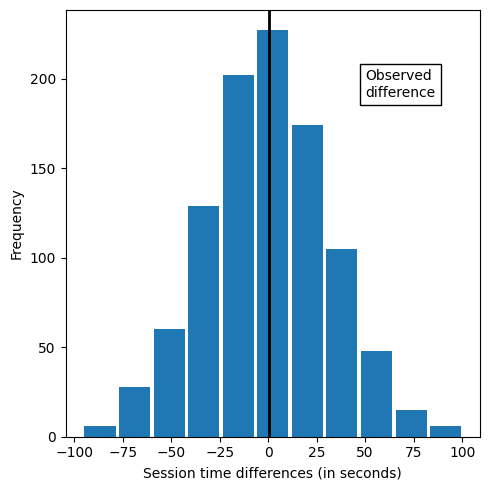

In [12]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color="black", lw=2)
ax.text(50, 190, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Session time differences (in seconds)")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [13]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.486


# Statistical Significance and P-Values

Observed difference: 0.0368%


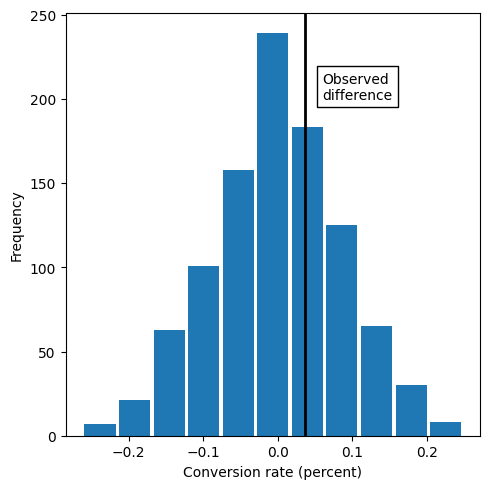

In [15]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f"Observed difference: {obs_pct_diff:.4f}%")
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588)
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color="black", lw=2)
ax.text(0.06, 200, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Conversion rate (percent)")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## P-Value
If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [16]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [17]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f"p-value for single sided test: {p_value / 2:.4f}")

p-value for single sided test: 0.3498


# t-Tests

In [19]:
res = stats.ttest_ind(session_times.filter(pl.col("page") == "Page A")["time"],
                      session_times.filter(pl.col("page") == "Page B")["time"],
                      equal_var=False)
print(f"p-value for single sided test: {res.pvalue / 2:.4f}")

p-value for single sided test: 0.1408


In [20]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times.filter(pl.col("page") == "Page A")["time"],
    session_times.filter(pl.col("page") == "Page B")["time"],
    usevar="unequal", alternative="smaller")
print(f"p-value: {pvalue:.4f}")

p-value: 0.1408


# ANOVA

In [26]:
four_sessions = pl.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by="page", column="time",
                           figsize=(4, 4))
ax.set_xlabel("Page")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")
plt.title("")

plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'boxplot'

In [22]:
print(pl.read_csv(FOUR_SESSIONS_CSV).head())

shape: (5, 2)
┌────────┬──────┐
│ page   ┆ time │
│ ---    ┆ ---  │
│ str    ┆ i64  │
╞════════╪══════╡
│ Page 1 ┆ 164  │
│ Page 2 ┆ 178  │
│ Page 3 ┆ 175  │
│ Page 4 ┆ 155  │
│ Page 1 ┆ 172  │
└────────┴──────┘


In [35]:
observed_variance = four_sessions.group_by("page").mean().var()[0]
# print("Observed means:", four_sessions.group_by("page").mean().ravel())
print("Variance:", observed_variance)

# Permutation test example with stickiness
def perm_test(df: pl.DataFrame):
    df = df.with_columns(
        time=np.random.permutation(df["time"]),
    )
    return df.group_by("page").mean().var()[0]

print(perm_test(four_sessions))

Variance: shape: (1, 2)
┌──────┬───────────┐
│ page ┆ time      │
│ ---  ┆ ---       │
│ str  ┆ f64       │
╞══════╪═══════════╡
│ null ┆ 55.426667 │
└──────┴───────────┘
shape: (1, 2)
┌──────┬───────┐
│ page ┆ time  │
│ ---  ┆ ---   │
│ str  ┆ f64   │
╞══════╪═══════╡
│ null ┆ 14.36 │
└──────┴───────┘


In [36]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print("Pr(Prob)", np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color="black", lw=2)
ax.text(60, 200, "Observed\nvariance", bbox={"facecolor": "white"})
ax.set_xlabel("Variance")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for +: 'NoneType' and 'bool'

## F-Statistic
We can compute an ANOVA table using statsmodel.

In [38]:
model = smf.ols("time ~ page", data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

TypeError: Cannot interpret 'String' as a data type

In [39]:
res = stats.f_oneway(four_sessions.filter(pl.col("page") == "Page 1")["time"],
                     four_sessions.filter(pl.col("page") == "Page 2")["time"],
                     four_sessions.filter(pl.col("page") == "Page 3")["time"],
                     four_sessions.filter(pl.col("page") == "Page 4")["time"])
print(f"F-Statistic: {res.statistic / 2:.4f}")
print(f"p-value: {res.pvalue / 2:.4f}")

F-Statistic: 1.3699
p-value: 0.0388


### Two-way anova only available with statsmodels

```python
formula = "len ~ C(supp) + C(dose) + C(supp):C(dose)"
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

# Chi-Square Test
## Chi-Square Test: A Resampling Approach

In [41]:
# Table 3-4
click_rate = pl.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index="click", columns="headline", values="rate")
print(clicks)

shape: (2, 4)
┌──────────┬────────────┬────────────┬────────────┐
│ click    ┆ Headline A ┆ Headline B ┆ Headline C │
│ ---      ┆ ---        ┆ ---        ┆ ---        │
│ str      ┆ i64        ┆ i64        ┆ i64        │
╞══════════╪════════════╪════════════╪════════════╡
│ Click    ┆ 14         ┆ 8          ┆ 12         │
│ No-click ┆ 986        ┆ 992        ┆ 988        │
└──────────┴────────────┴────────────┴────────────┘


In [44]:
# Table 3-5
row_average = clicks.mean_horizontal()
print(pl.DataFrame({
    "Headline A": row_average,
    "Headline B": row_average,
    "Headline C": row_average,
}))

shape: (2, 3)
┌────────────┬────────────┬────────────┐
│ Headline A ┆ Headline B ┆ Headline C │
│ ---        ┆ ---        ┆ ---        │
│ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╡
│ 11.333333  ┆ 11.333333  ┆ 11.333333  │
│ 988.666667 ┆ 988.666667 ┆ 988.666667 │
└────────────┴────────────┴────────────┘


In [46]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f"Observed chi2: {chi2observed:.4f}")
print(f"Resampled p-value: {resampled_p_value:.4f}")

TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [ ]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f"Observed chi2: {chisq:.4f}")
print(f"p-value: {pvalue:.4f}")

Observed chi2: 1.6659
p-value: 0.4348


The above algorithm uses sampling into the three sets without replacement. Alternatively, it is also possible to sample with replacement.

In [47]:
expected = [expected_clicks, expected_noclicks]
def sample_with_replacement(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f"Observed chi2: {chi2observed:.4f}")
print(f"Resampled p-value: {resampled_p_value:.4f}")

NameError: name 'chi2observed' is not defined

## Figure chi-sq distribution

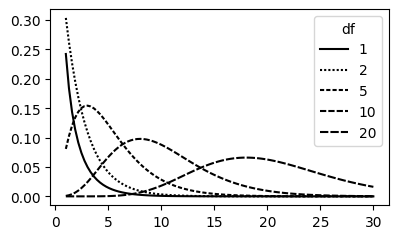

In [50]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pl.DataFrame({
    "x": x,
    "chi_1": stats.chi2.pdf(x, df=1),
    "chi_2": stats.chi2.pdf(x, df=2),
    "chi_5": stats.chi2.pdf(x, df=5),
    "chi_10": stats.chi2.pdf(x, df=10),
    "chi_20": stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi["x"], chi["chi_1"], color="black", linestyle="-", label="1")
ax.plot(chi["x"], chi["chi_2"], color="black", linestyle=(0, (1, 1)), label="2")
ax.plot(chi["x"], chi["chi_5"], color="black", linestyle=(0, (2, 1)), label="5")
ax.plot(chi["x"], chi["chi_10"], color="black", linestyle=(0, (3, 1)), label="10")
ax.plot(chi["x"], chi["chi_20"], color="black", linestyle=(0, (4, 1)), label="20")
ax.legend(title="df")

plt.tight_layout()
plt.show()

## Fisher's Exact Test

Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

In [ ]:
# stats.fisher_exact(clicks.values)

### Scientific Fraud

In [54]:
imanishi = pl.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x="digit", y=["frequency"], legend=False,
                       figsize=(4, 4))
ax.set_xlabel("Digit")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

AttributeError: 'Bars' object has no attribute 'set_xlabel'

# Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [55]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative="larger")
print("Sample Size: %.3f" % result)

Sample Size: 116602.393


In [56]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative="larger")
print("Sample Size: %.3f" % result)

Sample Size: 5488.408
